# Pràctica 4
### Part I : Entrenament de models Word2vec

In [ ]:
!python3 -m spacy download ca_core_news_sm
import spacy
nlp = spacy.load('ca_core_news_sm')


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: C:\Users\adria\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     --------------------------------------- 19.6/19.6 MB 38.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')


In [ ]:
from datasets import load_dataset
from nltk.tokenize import word_tokenize

dataset = load_dataset("projecte-aina/catalan_general_crawling")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset catalan_general_crawling downloaded and prepared to C:/Users/adria/.cache/huggingface/datasets/projecte-aina___catalan_general_crawling/default/1.0.0/fb8a4dbf3849d7aad584ad030c058c67c6a935ee7b8d6e37411514da9376a2fb. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
with open('data/ca_gen_crwlng.txt','w',encoding='UTF-8') as f:
    for i in dataset['train']['text']:
        f.write(i)

In [ ]:
from typing import List
from gensim.utils import simple_preprocess
STOPWORDS_CA = {"a", "al", "el", "la", "els", "les", "de", "un", "una", "algun", "alguna", }


def preprocess(sentence: str) -> List[str]:
    preprocessed = simple_preprocess(sentence)
    preprocessed = [token for token in preprocessed if token not in STOPWORDS_CA]
    return preprocessed

In [ ]:
def obtain_words(filepath:str) -> list[list[str]]:
    if filepath[-4:] != '.txt':
        raise Exception('Incorrect file path/name')

    txt_crps = []
    with open(filepath,'r',encoding='UTF-8') as f:
        lines = f.readlines()
        for l in lines:
            txt_crps.append(preprocess(l))

    return txt_crps

In [ ]:
txt_crps100 = obtain_words('data/ca_gen_crwlng100M.txt')
txt_crps500 = obtain_words('data/ca_gen_crwlng500M.txt')

##### Create Word2Vec models with the 2 sizes

In [ ]:
from gensim.models import word2vec
model100 = word2vec.Word2Vec(txt_crps100 , vector_size=300, window=5, min_count=10, workers=4, epochs=25, sg=1)
model500 = word2vec.Word2Vec(txt_crps500 , vector_size=300, window=5, min_count=10, workers=4, epochs=25, sg=1)

##### Save the models to easy load

In [ ]:
model100.wv.save_word2vec_format('data/word2vec100.bin', binary=True)
model500.wv.save_word2vec_format('data/word2vec500.bin', binary=True)

In [10]:
from gensim.models import KeyedVectors
wv100 = KeyedVectors.load_word2vec_format('data/word2vec100.bin', binary=True)
wv500 = KeyedVectors.load_word2vec_format('data/word2vec500.bin', binary=True)

## Text similarity training and comparison

### Obtain the corpus

In [7]:
from datasets import load_dataset

dataset = load_dataset("projecte-aina/sts-ca")

Found cached dataset sts-ca (C:/Users/pelot/.cache/huggingface/datasets/projecte-aina___sts-ca/StsCa/1.0.2/bad37fb7fb0f06f3d2316e29637293b25160a93a24f36f1974f21313ac2f3342)


  0%|          | 0/3 [00:00<?, ?it/s]

### Obtain the Baseline model

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 2073
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 500
    })
})

In [1]:
## Imports necessaris
#!py -m spacy download ca_core_news_md
#!py -m spacy download ca_core_news_trf

##!python3 -m pip install spacy-transformers
##!python3 -m pip install sentence_transformers

# Requisitos

from gensim.models import TfidfModel, KeyedVectors, fasttext
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np
# Tipado
from typing import Tuple, List, Optional
import spacy
import tensorflow as tf
from scipy.stats import pearsonr
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer
from scipy.special import logit



In [8]:

# Cargar stopwords en Catalan
# STOPWORDS_CA = {"a", "abans", "ací", "ah", "així", "això", "al", "aleshores", "algun", "alguna", "algunes", "alguns", "alhora", "allà", "allí", "allò", "als", "altra", "altre", "altres", "amb", "ambdues", "ambdós", "anar", "ans", "apa", "aquell", "aquella", "aquelles", "aquells", "aquest", "aquesta", "aquestes", "aquests", "aquí", "baix", "bastant", "bé", "cada", "cadascuna", "cadascunes", "cadascuns", "cadascú", "com", "consegueixo", "conseguim", "conseguir", "consigueix", "consigueixen", "consigueixes", "contra", "d'un", "d'una", "d'unes", "d'uns", "dalt", "de", "del", "dels", "des", "des de", "després", "dins", "dintre", "donat", "doncs", "durant", "e", "eh", "el", "elles", "ells", "els", "em", "en", "encara", "ens", "entre", "era", "erem", "eren", "eres", "es", "esta", "estan", "estat", "estava", "estaven", "estem", "esteu", "estic", "està", "estàvem", "estàveu", "et", "etc", "ets", "fa", "faig", "fan", "fas", "fem", "fer", "feu", "fi", "fins", "fora", "gairebé", "ha", "han", "has", "haver", "havia", "he", "hem", "heu", "hi", "ho", "i", "igual", "iguals", "inclòs", "ja", "jo", "l'hi", "la", "les", "li", "li'n", "llarg", "llavors", "m'he", "ma", "mal", "malgrat", "mateix", "mateixa", "mateixes", "mateixos", "me", "mentre", "meu", "meus", "meva", "meves", "mode", "molt", "molta", "moltes", "molts", "mon", "mons", "més", "n'he", "n'hi", "ne", "ni", "no", "nogensmenys", "només", "nosaltres", "nostra", "nostre", "nostres", "o", "oh", "oi", "on", "pas", "pel", "pels", "per", "per que", "perquè", "però", "poc", "poca", "pocs", "podem", "poden", "poder", "podeu", "poques", "potser", "primer", "propi", "puc", "qual", "quals", "quan", "quant", "que", "quelcom", "qui", "quin", "quina", "quines", "quins", "què", "s'ha", "s'han", "sa", "sabem", "saben", "saber", "sabeu", "sap", "saps", "semblant", "semblants", "sense", "ser", "ses", "seu", "seus", "seva", "seves", "si", "sobre", "sobretot", "soc", "solament", "sols", "som", "son", "sons", "sota", "sou", "sóc", "són", "t'ha", "t'han", "t'he", "ta", "tal", "també", "tampoc", "tan", "tant", "tanta", "tantes", "te", "tene", "tenim", "tenir", "teniu", "teu", "teus", "teva", "teves", "tinc", "ton", "tons", "tot", "tota", "totes", "tots", "un", "una", "unes", "uns", "us", "va", "vaig", "vam", "van", "vas", "veu", "vosaltres", "vostra", "vostre", "vostres", "érem", "éreu", "és", "éssent", "últim", "ús"}
STOPWORDS_CA = {"a", "al", "el", "la", "els", "les", "de", "un", "una", "algun", "alguna", }

# Definir función de pre-procesado
def preprocess(sentence: str) -> List[str]:
    preprocessed = simple_preprocess(sentence)
    preprocessed = [token for token in preprocessed if token not in STOPWORDS_CA]
    return preprocessed

## Introducir los datos de train y de validación
input_pairs = list(zip(dataset["train"]["sentence1"], dataset["train"]["sentence2"], dataset["train"]["label"]))
input_pairs_val = list(zip(dataset["validation"]["sentence1"], dataset["validation"]["sentence2"], dataset["validation"]["label"]))


# Preprocesamiento de las oraciones y creación del diccionario
sentences_1_preproc = [preprocess(sentence_1) for sentence_1, _, _ in input_pairs]
sentences_2_preproc = [preprocess(sentence_2) for _, sentence_2, _ in input_pairs]
sentence_pairs = list(zip(sentences_1_preproc, sentences_2_preproc))
# Versión aplanada para poder entrenar el modelo
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc

diccionario = Dictionary(sentences_pairs_flattened)

corpus = [diccionario.doc2bow(sent) for sent in sentences_pairs_flattened]
modelo_tfidf = TfidfModel(corpus)

def creacio_one_hot(sentence, diccionario:Dictionary):
    diccionario.filter_extremes(no_below=5, no_above=0.5, keep_n=100)
    vector1 = np.zeros(len(diccionario.token2id), dtype=np.float)
    bow1 = diccionario.doc2bow(sentence)
    for index, count in bow1:
        vector1[index] = count

    return vector1

def map_tf_idf(sentence_preproc: List[str], dictionary: Dictionary, tf_idf_model: TfidfModel, wv_model) -> Tuple[List[np.ndarray], List[float]]:
    bow = dictionary.doc2bow(sentence_preproc)
    tf_idf = tf_idf_model[bow]
    vectors, weights = [], []
    for word_index, weight in tf_idf:
        word = dictionary.get(word_index)
        if word in wv_model:
            vectors.append(wv_model[word])
            weights.append(weight)
    return vectors, weights

def map_pairs(
        sentence_pairs: List[Tuple[str, str, float]],
        dictionary: Dictionary = None,
        tf_idf_model: TfidfModel = None,
        one_hot: bool = None,
        Spasii : bool = None,
        RobertA: bool = None,
        RobertA_Mean: bool = None,
        wv100: bool = None,
        wv500: bool = None,
        w2v_pre_mean: bool = None,
        RobertA_finetuned: bool = None
) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    """
    Mapea los tripletes de oraciones a listas de (x, y), (pares de vectores, score)
    :param sentence_pairs:
    :param dictionary:
    :param tf_idf_model:
    :return:
    """
    if one_hot:
        dictionary2 = Dictionary(sentences_pairs_flattened, prune_at=300)

    if Spasii:
        nlp = spacy.load("ca_core_news_md")
    if RobertA or RobertA_Mean:
        nlp = spacy.load("ca_core_news_trf")

    if wv100:
        wv_model = KeyedVectors.load_word2vec_format("data/word2vec100.bin", binary = True)

    if wv500:
        wv_model = KeyedVectors.load_word2vec_format("data/word2vec500.bin", binary = True)

    if w2v_pre_mean or tf_idf_model:
        wv_model = KeyedVectors.load_word2vec_format("data/model.bin", binary = True)

    if RobertA_finetuned:
        model = 'projecte-aina/roberta-base-ca-cased-sts'
        tokenizer = AutoTokenizer.from_pretrained(model)
        pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)


    # Mapeo de los pares de oraciones a pares de vectores
    pares_vectores = []
    for i, (sentence_1, sentence_2, similitud) in enumerate(sentence_pairs):
        sentence_1_preproc = preprocess(sentence_1)
        sentence_2_preproc = preprocess(sentence_2)
        # Si usamos TF-IDF
        if tf_idf_model is not None:
            # Cálculo del promedio ponderado por TF-IDF de los word embeddings
            vectors1, weights1 = map_tf_idf(sentence_1_preproc, dictionary=dictionary, tf_idf_model=tf_idf_model, wv_model=wv_model )
            vectors2, weights2 = map_tf_idf(sentence_2_preproc, dictionary=dictionary, tf_idf_model=tf_idf_model,wv_model=wv_model )
            vector1 = np.average(vectors1, weights=weights1, axis=0, )
            vector2 = np.average(vectors2, weights=weights2, axis=0, )

        elif wv100 is not None:
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vectors2 = [wv_model[word] for word in sentence_2_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)
            vector2 = np.mean(vectors2, axis=0)

        elif wv500 is not None:
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vectors2 = [wv_model[word] for word in sentence_2_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)
            vector2 = np.mean(vectors2, axis=0)

        elif one_hot is not None:
            vector1 = creacio_one_hot(sentence=sentence_1_preproc, diccionario=dictionary2)
            vector2 = creacio_one_hot(sentence=sentence_2_preproc, diccionario= dictionary2)
            
        elif Spasii is not None:
            vector1 = nlp(" ".join(sentence_1_preproc)).vector
            vector2 = nlp(" ".join(sentence_2_preproc)).vector

        elif RobertA is not None:
            vector1 = nlp(" ".join(sentence_1_preproc))._.trf_data.tensors[-1]
            vector2 = nlp(" ".join(sentence_2_preproc))._.trf_data.tensors[-1]
            vector1 = tf.squeeze(vector1)
            vector2 = tf.squeeze(vector2)

        elif RobertA_Mean is not None:
            vectors1 = nlp(" ".join(sentence_1_preproc))._.trf_data.tensors[-1]
            vectors2 = nlp(" ".join(sentence_2_preproc))._.trf_data.tensors[-1]
            vector1 = np.average(vectors1, axis=0)
            vector2 = np.average(vectors2, axis=0)

        elif RobertA_finetuned is not None:
            vector1 = model.encode(" ".join(sentence_1_preproc))
            vector2 = model.encode(" ".join(sentence_2_preproc))
            vector1 = tf.squeeze(vector1)
            vector2 = tf.squeeze(vector2)

            
        elif w2v_pre_mean is not None:
            # Cálculo del promedio de los word embeddings
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vectors2 = [wv_model[word] for word in sentence_2_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)
            vector2 = np.mean(vectors2, axis=0)
        # Añadir a la lista
        pares_vectores.append(((vector1, vector2), similitud))
    return pares_vectores

Fem la funció de la creació del model y dels hiperparámetres

In [56]:
def build_and_compile_model(hidden_size: int = 128, embedding_size: int = 300, learning_rate: float = 0.001) -> tf.keras.Model:
    # Capa de entrada para los pares de vectores
    input_1 = tf.keras.Input(shape=(embedding_size,))
    input_2 = tf.keras.Input(shape=(embedding_size,))

    # Capa oculta
    first_projection = tf.keras.layers.Dense(
        embedding_size,
        # activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
    )
    projected_1 = first_projection(input_1)
    projected_2 = first_projection(input_2)

    # Compute the cosine distance
    projected_1 = tf.linalg.l2_normalize(projected_1, axis=1, )
    projected_2 = tf.linalg.l2_normalize(projected_2, axis=1, )
    output = 2.5 * (1.0 + tf.reduce_sum(projected_1 * projected_2, axis=1, ))

    # Definir el modelo con las capas de entrada y salida
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

    def pearson_correlation(y_true, y_pred):
        print(y_pred, y_true)
        # Calcular la correlación de Pearson entre los valores verdaderos y los valores predichos
        corr, _ = pearsonr(tf.squeeze(y_true), tf.squeeze(y_pred))
        return corr

    # Compilar el modelo
    model.compile(loss='mean_absolute_error', metrics=tf.keras.metrics.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate))

    return model

def plot_training_curve(history):
    # Plot the training and validation loss and accuracy
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].grid(True)
    ax[0].legend()
    ax[1].plot(history.history['mean_squared_error'], label='mean_squared_error')
    ax[1].plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Training and Validation correlation')
    ax[1].grid(True)
    ax[1].legend()
    plt.show()

# Definir constantes de entrenamiento
batch_size: int = 64
num_epochs: int = 64

def pair_list_to_x_y(pair_list: List[Tuple[Tuple[np.ndarray, np.ndarray], int]]) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    """
    Otiene las matrices X_1 (N x d) , X_2 (N x d), e Y (n) a partir de listas de parejas de vectores de oraciones - Listas de (d, d, 1)
    :param pair_list:
    :return:
    """
    _x, _y = zip(*pair_list)
    _x_1, _x_2 = zip(*_x)
    return (np.array(_x_1), np.array(_x_2)), np.array(_y, dtype=np.float32, )


def create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size:int=100):
    # Obtener las listas de train y test
    x_train, y_train = pair_list_to_x_y(mapped)
    x_val, y_val = pair_list_to_x_y(mapped_val)

    # Preparar los conjuntos de datos de entrenamiento y validación
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    # Construir y compilar el modelo
    model = build_and_compile_model(embedding_size=embedding_size)
    # tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, )
    print(model.summary())
    # Entrenar el modelo
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

    plot_training_curve(history)

    y_pred: tf.RaggedTensor = model.predict(x_val)
    # Calcular la correlación de Pearson entre las predicciones y los datos de prueba
    correlation, _ = pearsonr(y_pred.flatten(), y_val.flatten())
    # Imprimir el coeficiente de correlación de Pearson
    print(f"Correlación de Pearson: {correlation}")

    return model

### Compare results with different word embeddings

#### 0. Model de Word2Vec entrenats per nosaltres

##### 0.1. Model amb 100 MB

In [47]:
mapped = map_pairs(input_pairs, wv100=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, wv100=True, dictionary=diccionario)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 100)          10100       ['input_31[0][0]',               
                                                                  'input_32[0][0]']               
                                                                                                  
 tf.math.l2_normalize_30 (TFOpL  (None, 100)         0           ['dense_9[0][0]']         

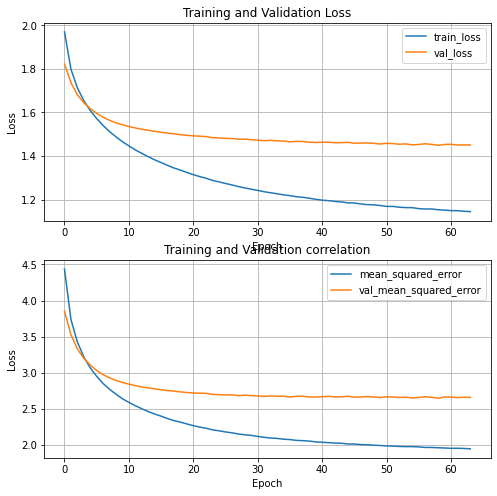

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.44599953275335824


In [50]:
model = create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size=100)

##### 0.2. Model amb 500 MB

In [51]:
mapped = map_pairs(input_pairs, wv500=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, wv500=True, dictionary=diccionario)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 100)          10100       ['input_33[0][0]',               
                                                                  'input_34[0][0]']               
                                                                                                  
 tf.math.l2_normalize_32 (TFOpL  (None, 100)         0           ['dense_10[0][0]']        

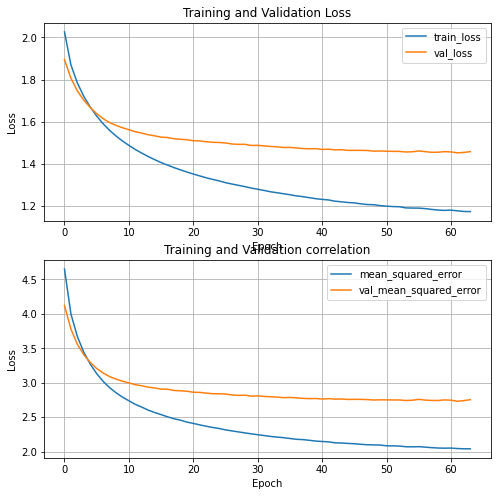

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.35885052472452256


In [52]:
model = create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size=100)

#### 1. One Hot encoding

In [57]:
mapped = map_pairs(input_pairs, one_hot=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, one_hot=True, dictionary=diccionario)

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 100)          10100       ['input_37[0][0]',               
                                                                  'input_38[0][0]']               
                                                                                                  
 tf.math.l2_normalize_36 (TFOpL  (None, 100)         0           ['dense_12[0][0]']        

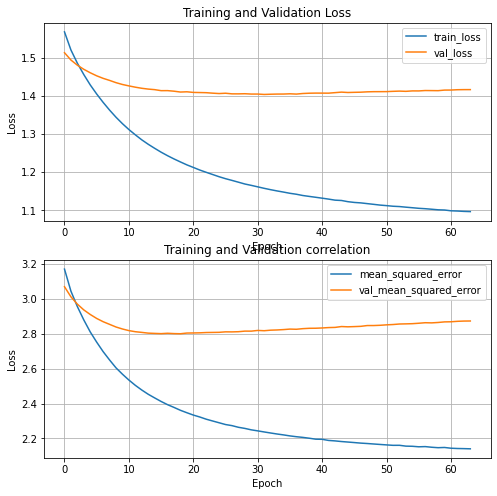

16/16 [==============================] - 0s 1ms/step
Correlación de Pearson: 0.22115282243433215


In [58]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=100)

#### 2. Models de Word2Vec/GloVe pre-entrenats

##### 2.1.Word2Vec + Mean

In [64]:
mapped = map_pairs(input_pairs, w2v_pre_mean=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, w2v_pre_mean=True, dictionary=diccionario)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 100)          10100       ['input_43[0][0]',               
                                                                  'input_44[0][0]']               
                                                                                                  
 tf.math.l2_normalize_42 (TFOpL  (None, 100)         0           ['dense_15[0][0]']        

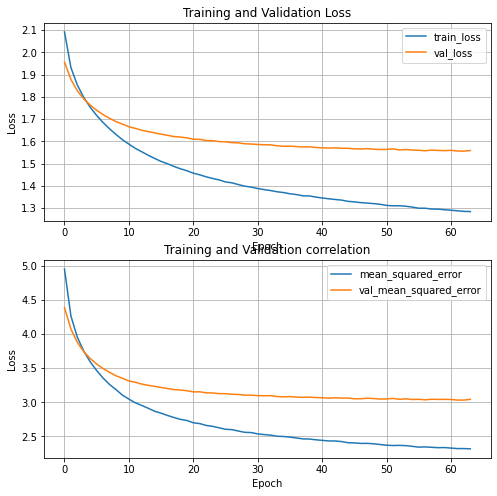

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.31672707213798534


In [65]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=100)

##### 2.2.Word2Vec + Mean ponderada (TF-IDF)

In [66]:
mapped = map_pairs(input_pairs, tf_idf_model=modelo_tfidf, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, tf_idf_model=modelo_tfidf, dictionary=diccionario)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 100)          10100       ['input_45[0][0]',               
                                                                  'input_46[0][0]']               
                                                                                                  
 tf.math.l2_normalize_44 (TFOpL  (None, 100)         0           ['dense_16[0][0]']        

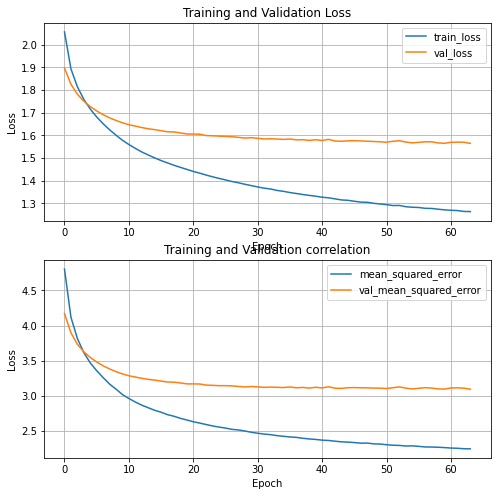

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.30036529222154734


In [67]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=100)

#### 3.Spacy

Primer definim els embeddings amb el model de Spacy

In [68]:
mapped = map_pairs(input_pairs, Spasii=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, Spasii=True, dictionary=diccionario)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_50 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 300)          90300       ['input_49[0][0]',               
                                                                  'input_50[0][0]']               
                                                                                                  
 tf.math.l2_normalize_48 (TFOpL  (None, 300)         0           ['dense_18[0][0]']        

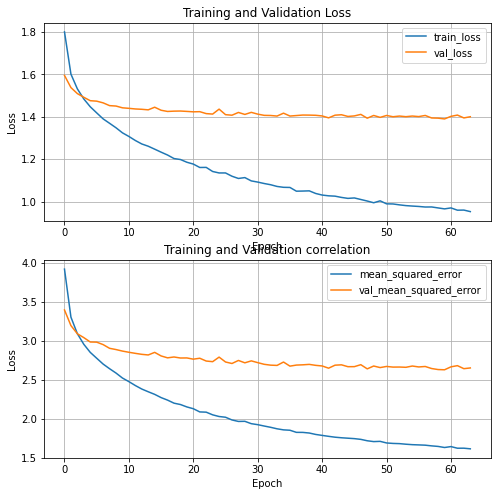

16/16 [==============================] - 0s 2ms/step
Correlación de Pearson: 0.27898310913701463


In [70]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=300)

#### 4.RoBERTa

##### 4.1.CLS

In [75]:
# (Amb spaCy, doc._.trf_data.tensors[-1])
mapped = map_pairs(input_pairs, RobertA=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, RobertA=True, dictionary=diccionario)

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_56 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 dense_21 (Dense)               (None, 768)          590592      ['input_55[0][0]',               
                                                                  'input_56[0][0]']               
                                                                                                  
 tf.math.l2_normalize_54 (TFOpL  (None, 768)         0           ['dense_21[0][0]']        

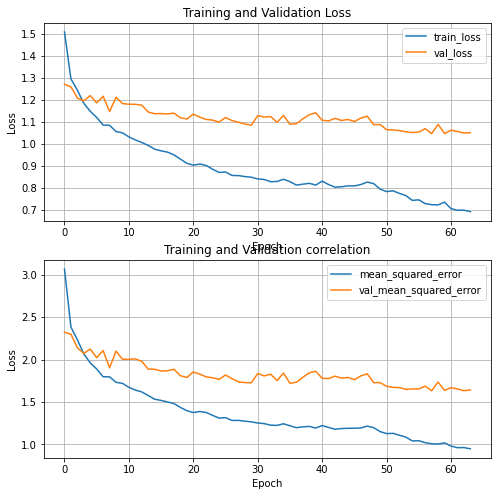

16/16 [==============================] - 0s 5ms/step
Correlación de Pearson: 0.21085842253443662


In [76]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=768)

##### 4.2.MEAN

In [80]:
# (Amb spaCy, doc._.trf_data.tensors[-1])
mapped = map_pairs(input_pairs, RobertA_Mean=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, RobertA_Mean=True, dictionary=diccionario)

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_60 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 dense_23 (Dense)               (None, 768)          590592      ['input_59[0][0]',               
                                                                  'input_60[0][0]']               
                                                                                                  
 tf.math.l2_normalize_58 (TFOpL  (None, 768)         0           ['dense_23[0][0]']        

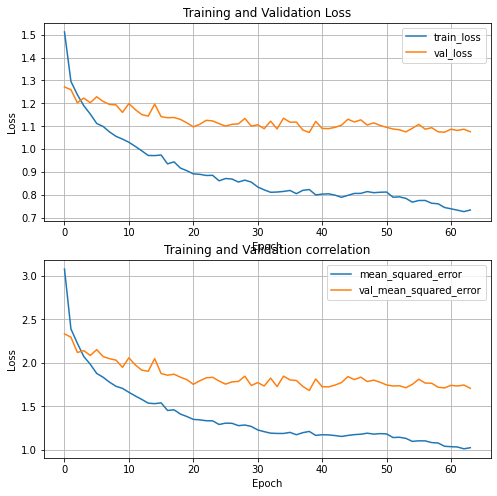

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.2195821902305396


In [81]:
model = create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size=768)

#### 5.RoBERTa FineTuned

In [5]:
from transformers import pipeline, AutoTokenizer
from scipy.special import logit

model = 'projecte-aina/roberta-base-ca-v2-cased-sts'
tokenizer = AutoTokenizer.from_pretrained(model)
pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)

def prepare(sentence_pairs):
    sentence_pairs_prep = []
    for s1, s2, _ in sentence_pairs:
        sentence_pairs_prep.append(f"{tokenizer.cls_token} {s1}{tokenizer.sep_token}{tokenizer.sep_token} {s2}{tokenizer.sep_token}")
    return sentence_pairs_prep


C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pelot\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [15]:
predictions = pipe(prepare(input_pairs_val), add_special_tokens=False)

# convert back to scores to the original 0 and 5 interval
valors_pred = []
valors_reals = []
for prediction, real in zip(predictions, input_pairs_val):
    valors_pred.append(logit(prediction['score']))
    valors_reals.append(real[2])

correlation, _ = pearsonr(valors_pred, valors_reals)
# Imprimir el coeficiente de correlación de Pearson
print(f"Correlación de Pearson: {correlation}")

Correlación de Pearson: 0.7522604358087148


## Train the same model with initiated trainable embeddings

In [24]:
# Preprocesamiento de las oraciones y creación del diccionario
sentences_1_preproc = [simple_preprocess(sentence_1) for sentence_1, _, _ in input_pairs]
sentences_2_preproc = [simple_preprocess(sentence_2) for _, sentence_2, _ in input_pairs]
sentence_pairs = list(zip(sentences_1_preproc, sentences_2_preproc))
# Versión aplanada para poder entrenar el modelo
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc
diccionario = Dictionary(sentences_pairs_flattened)
REMAP_EMBEDDINGS = True
wv_model = None

def map_word_embeddings(
        sentence: str,
        sequence_len: int = 32,
        fixed_dictionary: Optional[Dictionary] = None
) -> np.ndarray:
    """
    Map to word-embedding indices
    :param sentence:
    :param sequence_len:
    :param fixed_dictionary:
    :return:
    """
    sentence_preproc = simple_preprocess(sentence)
    _vectors = np.zeros(sequence_len, dtype=np.int32)
    index = 0
    for word in sentence_preproc:
        if fixed_dictionary is not None:
            if word in fixed_dictionary.token2id:
                # Sumo 1 porque el valor 0 está reservado a padding
                _vectors[index] = fixed_dictionary.token2id[word] + 1
                index += 1
        else:
            if word in wv_model.key_to_index:
                _vectors[index] = wv_model.key_to_index[word] + 1
                index += 1
    return _vectors


def map_pairs(
        sentence_pairs: List[Tuple[str, str, float]],
        sequence_len: int = 32,
        fixed_dictionary: Optional[Dictionary] = None
) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    """
    Mapea los tripletes de oraciones a listas de (x, y), (pares de vectores, score)
    :param sentence_pairs:
    :param sequence_len:
    :param fixed_dictionary:
    :return:
    """
    # Mapeo de los pares de oraciones a pares de vectores
    pares_vectores = []
    for i, (sentence_1, sentence_2, similitud) in enumerate(sentence_pairs):
        vector1 = map_word_embeddings(sentence_1, sequence_len, fixed_dictionary)
        vector2 = map_word_embeddings(sentence_2, sequence_len, fixed_dictionary)
        # Añadir a la lista
        pares_vectores.append(((vector1, vector2), similitud))
    return pares_vectores

mapped = map_pairs(input_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None)
mapped_val = map_pairs(input_pairs_val, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None)



In [25]:
# Definir el Modelo
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
def build_and_compile_model(
        input_length: int = 32,
        hidden_size: int = 64,
        dictionary_size: int = 1000,
        embedding_size: int = 16,
        pretrained_weights: Optional[np.ndarray] = None,
        learning_rate: float = 0.001,
        trainable: bool = False,
) -> tf.keras.Model:
    """
    Este es un modelo muy básico. Hace lo mismo que el modelo single_vector. La puntuación es mejor por no eliminar stopwords.
    :param input_length:
    :param hidden_size:
    :param dictionary_size:
    :param embedding_size:
    :param pretrained_weights:
    :param learning_rate:
    :param trainable:
    :return:
    """
    input_1, input_2 = tf.keras.Input((input_length, ), dtype=tf.int32, ), tf.keras.Input((input_length, ), dtype=tf.int32, )
    # Define Layers
    if pretrained_weights is None:
        embedding = tf.keras.layers.Embedding(
            dictionary_size, embedding_size, input_length=input_length, mask_zero=True, )
    else:
        dictionary_size = pretrained_weights.shape[0]
        embedding_size = pretrained_weights.shape[1]
        initializer = tf.keras.initializers.Constant(pretrained_weights)
        embedding = tf.keras.layers.Embedding(
            dictionary_size, embedding_size, input_length=input_length, mask_zero=True,
            embeddings_initializer=initializer, trainable=trainable, )
    pooling = tf.keras.layers.GlobalAveragePooling1D()
    # Pass through the layers
    _input_mask_1, _input_mask_2 = tf.not_equal(input_1, 0), tf.not_equal(input_2, 0)
    _embedded_1, _embedded_2 = embedding(input_1, ), embedding(input_2, )
    _pooled_1, _pooled_2 = pooling(_embedded_1, mask=_input_mask_1), pooling(_embedded_2, mask=_input_mask_2)

    # Compute the cosine distance
    projected_1 = tf.linalg.l2_normalize(_pooled_1, axis=1, )
    projected_2 = tf.linalg.l2_normalize(_pooled_2, axis=1, )
    output = 2.5 * (1.0 + tf.reduce_sum(projected_1 * projected_2, axis=1, ))

    # Define the model
    model = tf.keras.Model(inputs=(input_1, input_2, ), outputs=output,)
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

def create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size:int=300):
    # Obtener las listas de train y test
    x_train, y_train = pair_list_to_x_y(mapped)
    x_val, y_val = pair_list_to_x_y(mapped_val)

    # Preparar los conjuntos de datos de entrenamiento y validación
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    # Construir y compilar el modelo
    model = build_and_compile_model(pretrained_weights=None, dictionary_size=len(diccionario.token2id)+1)
    # tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, )
    print(model.summary())
    # Entrenar el modelo
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

    plot_training_curve(history)

    y_pred: tf.RaggedTensor = model.predict(x_val)
    # Calcular la correlación de Pearson entre las predicciones y los datos de prueba
    correlation, _ = pearsonr(y_pred.flatten(), y_val.flatten())
    # Imprimir el coeficiente de correlación de Pearson
    print(f"Correlación de Pearson: {correlation}")

    return model

#### Random Embeddings (uniforme)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 32, 16)       162880      ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 tf.math.not_equal_10 (TFOpLamb  (None, 32)          0           ['input_11[0][0]']         

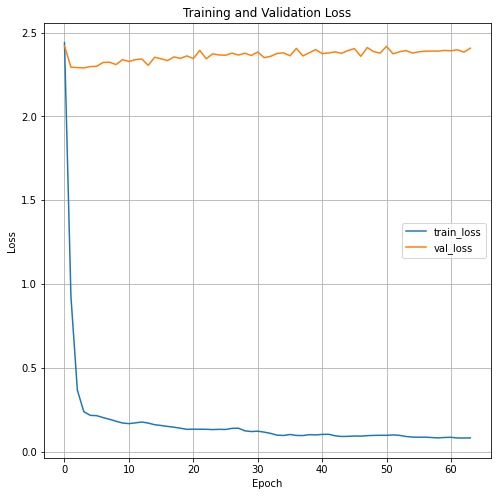

16/16 [==============================] - 0s 4ms/step
Correlación de Pearson: 0.3110238613906671


In [26]:
create_and_train_and_evaluate_model(mapped, mapped_val)

#### Word2Vec

## Analyze results